In [1]:
%run scripts/defaultStartUp.py
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MaxAbsScaler, FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import mca

In [225]:
import collections
import itertools
import string
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import scipy.stats
import calendar
from math import gcd
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib.colorbar as cb
import connect_LAV
from ipython_pg.connect_LAV import connect
from IPython.core.display import display, HTML            # display(HTML(df.to_html())) !!!!!
from gp_learning import *
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 300

In [284]:
conn = connect(user='giacompa', host='lav-fileserver', port='5433', dbname='mobility')

password for giacompa@lav-fileserver:5433:········


In [285]:
sql = ['SELECT "f41300" target,',
        '"f40800_01",',
        #'"f41100_01",',
        #'"f41102",',
        '"ESTATUS",',
        '"BSTELL",',
        '"wiabt_08",',
        '"SBN2000_1",',
        '"ISCO_08"',
    'FROM mzmv2015.zielpersonen',
    'WHERE "f41300" > 0 AND',
        '"wiabt_08" > 0 AND',         
        '"SBN2000_1" > 0 AND',
        '"ISCO_08" >= 0 AND',    # to avoid -99 and so
        'alter >= 18']

sql = "\n ".join(sql)
df = pd.read_sql(sql=sql, con=conn)

In [286]:
df.describe()

,target,f40800_01,ESTATUS,BSTELL,wiabt_08,SBN2000_1,ISCO_08
count,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000
mean,1.683023,3.638691,2.734236,29.702876,10.749690,5.550931,3.860688
std,0.833586,0.971835,0.725678,7.576307,5.872533,2.180465,2.222022
min,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,0.000000
25%,1.000000,4.000000,3.000000,32.000000,6.000000,4.000000,2.000000
50%,1.000000,4.000000,3.000000,33.000000,11.000000,6.000000,3.000000
75%,2.000000,4.000000,3.000000,33.000000,16.000000,7.000000,5.000000
max,3.000000,5.000000,4.000000,40.000000,88.000000,9.000000,9.000000


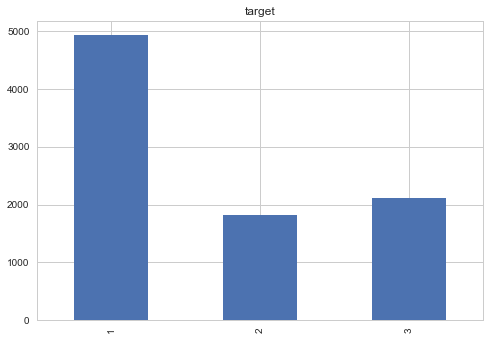

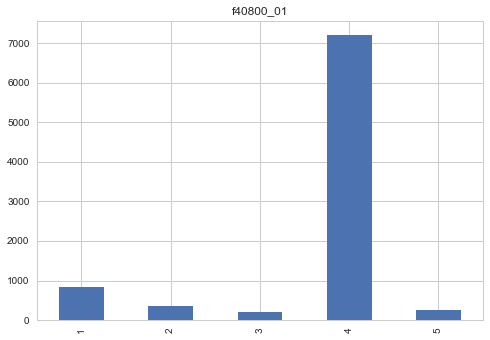

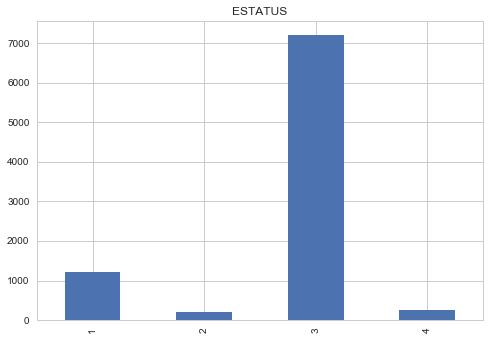

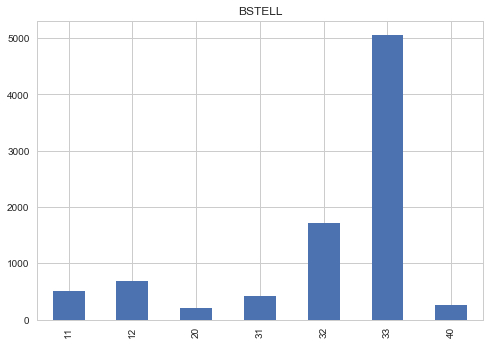

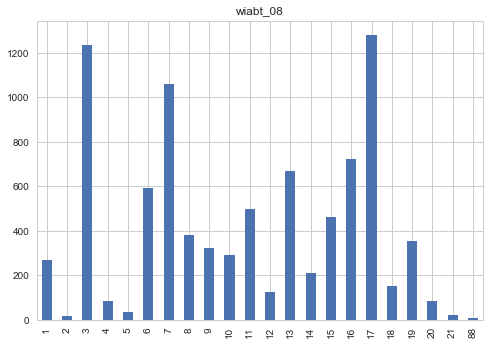

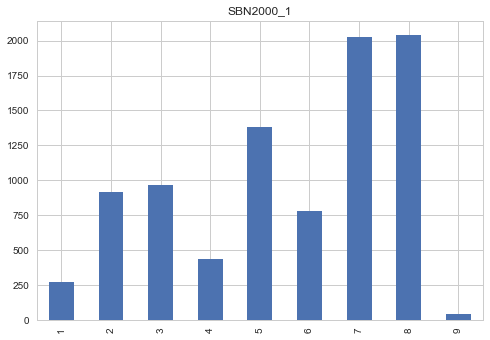

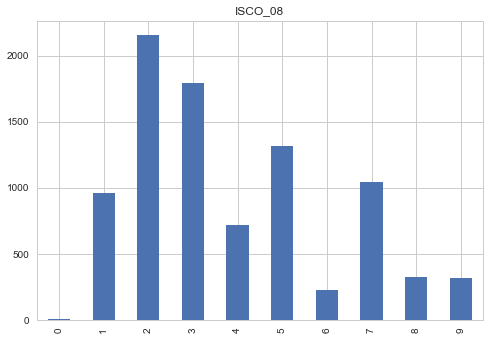

target       None
f40800_01    None
ESTATUS      None
BSTELL       None
wiabt_08     None
SBN2000_1    None
ISCO_08      None
dtype: object

In [287]:
df.apply(lambda col: plt.show(col.value_counts().sort_index().plot(kind='bar', title=col.name)))

In [288]:
data = df.drop('target', axis=1)
data.head(3)

,f40800_01,ESTATUS,BSTELL,wiabt_08,SBN2000_1,ISCO_08
0,2,1,11,3,2,7
1,4,3,33,15,7,3
2,4,3,32,8,5,1


Understanding the most important parameters; unsupervised

## MCA

Creating Multiindex

In [289]:
upper_level = []
for col in data:
    upper_level.extend([col]*len(data[col].unique()))     # repeting multiple times the feature name
lower_level = data.apply(lambda col: list(np.sort(col.unique()))).sum()
col_index = pd.MultiIndex.from_arrays([upper_level, lower_level], names = ['feature','value'])

In [290]:
data = pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(data), columns=col_index)
data.head(3)

feature f40800_01                     ESTATUS                BSTELL            \
value          1    2    3    4    5       1    2    3    4      11   12   20   
0             0.0  1.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0    1.0  0.0  0.0   
1             0.0  0.0  0.0  1.0  0.0     0.0  0.0  1.0  0.0    0.0  0.0  0.0   
2             0.0  0.0  0.0  1.0  0.0     0.0  0.0  1.0  0.0    0.0  0.0  0.0   

feature                     wiabt_08                                          \
value     31   32   33   40       1    2    3    4    5    6    7    8    9    
0        0.0  0.0  0.0  0.0      0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.0  0.0  1.0  0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.0  1.0  0.0  0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

feature                                                                   \
value     10   11   12   13   14   15   16   17   18   19   20   21   88   
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

feature SBN2000_1                                         ISCO_08            \
value          1    2    3    4    5    6    7    8    9       0    1    2    
0             0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   
1             0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0   
2             0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0   

feature                                     
value     3    4    5    6    7    8    9   
0        0.0  0.0  0.0  0.0  1.0  0.0  0.0  
1        1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [291]:
mca_ = mca.MCA(data, ncols=6, TOL=1e-4, benzecri=True)    # cols=list(data.columns)

In [292]:
mca_.L   # all

array([ 0.27152548,  0.1820773 ,  0.17446502,  0.05852023,  0.04500943,
        0.03756562,  0.03527431,  0.01674762,  0.00784738,  0.00560538,
        0.0054345 ,  0.00349833,  0.00243606,  0.00097542,  0.00053596,
        0.00044172])

In [297]:
expl = mca_.expl_var(N=30, greenacre=False)   # all
expl

array([  3.20171254e-01,   2.14697777e-01,   2.05721699e-01,
         6.90045569e-02,   5.30732038e-02,   4.42957727e-02,
         4.15939611e-02,   1.97480765e-02,   9.25329318e-03,
         6.60962639e-03,   6.40812713e-03,   4.12508510e-03,
         2.87249905e-03,   1.15017418e-03,   6.31980112e-04,
         5.20854942e-04,   1.09912226e-04,   8.85885732e-06,
         3.11060186e-06,   1.23037655e-07,   5.43450973e-08,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [298]:
mca_.L / expl[:16]

array([ 0.84806326,  0.84806326,  0.84806326,  0.84806326,  0.84806326,
        0.84806326,  0.84806326,  0.84806326,  0.84806326,  0.84806326,
        0.84806326,  0.84806326,  0.84806326,  0.84806326,  0.84806326,
        0.84806326])

In any case, with or without greenacre correction, the eigenvalues `mca_.L` and the corresponding propotion of explained inertia `mca_.expl_var` are proportional, but never equal

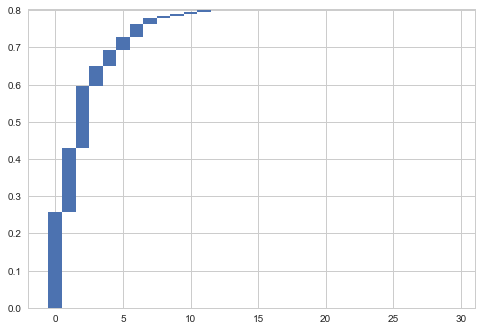

In [294]:
plt.bar(range(len(expl)), expl, 1.0, np.concatenate(([0], np.cumsum(expl)[:-1])));

Taking only 7 most important eigenvalues, and relative contributions

In [306]:
eigen = np.array([mca_.L[:7], 
                  mca_.expl_var(greenacre=False, N=7)]).T            # greenacre correction?
df_eigen = pd.DataFrame(data=eigen, columns=['cλ','%c'], index=range(1,8))
df_eigen['ratio'] = df_eigen['cλ'] / df_eigen['%c']
df_eigen

,cλ,%c,ratio
1,0.271525,0.320171,0.848063
2,0.182077,0.214698,0.848063
3,0.174465,0.205722,0.848063
4,0.058520,0.069005,0.848063
5,0.045009,0.053073,0.848063
6,0.037566,0.044296,0.848063
7,0.035274,0.041594,0.848063


Contributions on observations (`_r`)

In [74]:
n = 2000   # number of observation to show as example
f = 2   # number of factors
fs, cos, cont = 'Factor score', 'Squared cosines', 'Contributions x 100'
table3 = pd.DataFrame(columns=data[:n].index,                                  # columns as the single entries/observations of data
                      index=pd.MultiIndex.from_product([[fs, cos, cont], range(1, f+1)]))                   # rows, for every property the first f factors

table3.loc[fs,    :] = mca_.fs_r(N=f)[:n,:].T
table3.loc[cos,   :] = mca_.cos_r(N=f)[:n,:].T
table3.loc[cont,  :] = mca_.cont_r(N=f)[:n,:].T * 100
# table3.loc[fs, 'W?'] = mca_ben.fs_r_sup(pd.DataFrame([i_sup]), N=2)[0]
# np.round(table3.astype(float), 2)

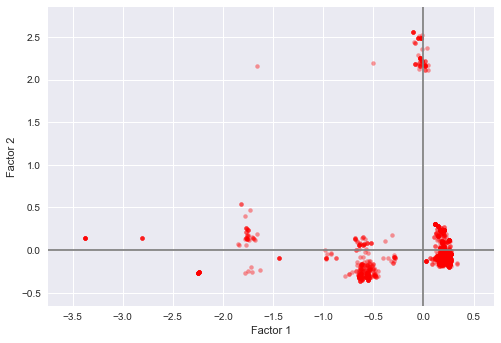

In [79]:
points = table3.loc[fs].values

plt.figure()
plt.margins(0.1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.scatter(*points, s=20, marker='o', c='r', alpha=.4, linewidths=0)
plt.show()

Contributions on **variables** (`_s`)

In [301]:
f = 7      #   number of factors
table4 = pd.DataFrame(columns=col_index,
                      index=pd.MultiIndex.from_product([[fs, cos, cont], range(1, f+1)]))
table4.loc[fs,  :] = mca_.fs_c(N=f).T
table4.loc[cos, :] = mca_.cos_c(N=f).T
table4.loc[cont,:] = mca_.cont_c(N=f).T * 100

# np.round(table4.astype(float), 2)

By comparing the "average **contribution** of the features to the principal factors (components)"

In [276]:
table4.loc[cont].sum(axis=0).groupby('feature').mean().sort_values(ascending=False)

feature
ESTATUS      24.186592
f40800_01    20.689038
SBN2000_1    16.308341
BSTELL       15.609355
ISCO_08      12.883791
wiabt_08      5.224090
dtype: float64

By comparing the "average **absolute factor score** of the features to form the principal factors (components)"

In [277]:
np.abs(table4.loc[fs]).sum(axis=0).groupby('feature').mean().sort_values(ascending=False)

feature
ESTATUS      3.796351
f40800_01    3.692431
BSTELL       2.943731
ISCO_08      1.786143
SBN2000_1    1.656943
wiabt_08     1.416976
dtype: float64

By comparing the "average **squared cosines** of the features with the principal factors (components)"

In [176]:
table4.loc[cos].sum(axis=0).groupby('feature').mean().sort_values(ascending=False)

feature
ESTATUS      0.665988
f40800_01    0.590012
BSTELL       0.521526
wiabt_08     0.192046
ISCO_08      0.181836
SBN2000_1    0.176827
dtype: float64

**contribution**

In [310]:
table4.loc[cont].apply(lambda col: col.multiply(df_eigen['%c'])).sum(axis=0).groupby('feature').mean().sort_values(ascending=False)

feature
ESTATUS      5.112567
f40800_01    4.176241
BSTELL       3.009895
SBN2000_1    1.295408
ISCO_08      1.105269
wiabt_08     0.442896
dtype: float64

**absolute factor score**

In [312]:
np.abs(table4.loc[fs]).apply(lambda col: col.multiply(df_eigen['%c'])).sum(axis=0).groupby('feature').mean().sort_values(ascending=False)

feature
ESTATUS      0.793801
f40800_01    0.756647
BSTELL       0.591152
ISCO_08      0.246450
SBN2000_1    0.222971
wiabt_08     0.198581
dtype: float64

As above, weighing the principal components with the relative explained inertia `df_eigen['%c']`:

**square cosines**

In [309]:
table4.loc[cos].apply(lambda col: col.multiply(df_eigen['%c'])).sum(axis=0).groupby('feature').mean().sort_values(ascending=False)

feature
ESTATUS      0.248281
f40800_01    0.235576
BSTELL       0.208689
wiabt_08     0.102657
ISCO_08      0.089772
SBN2000_1    0.081749
dtype: float64

When finding similar feature maps (below with the spider plots), the aboe rankings should be used to choose what to keep

For the plot, only first 2 components are possible

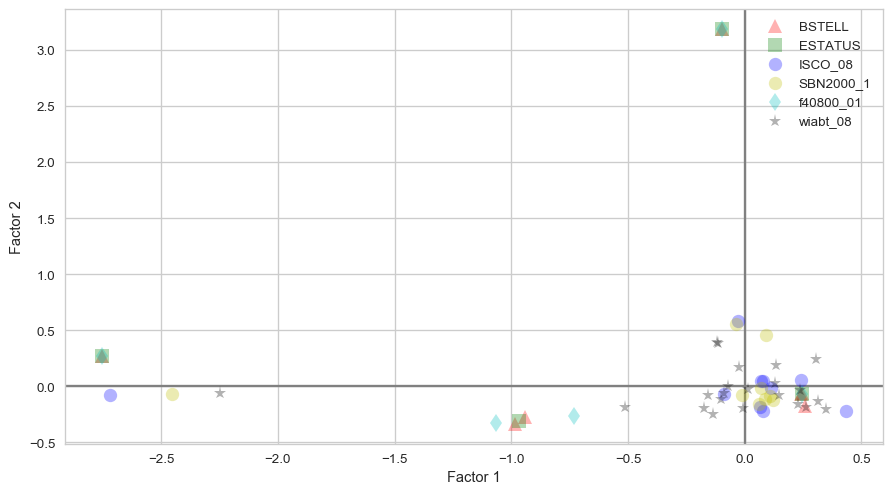

In [314]:
f = 2      #   number of factors
table4 = pd.DataFrame(columns=col_index,
                      index=pd.MultiIndex.from_product([[fs], range(1, f+1)]))
table4.loc[fs,  :] = mca_.fs_c(N=f).T

sns.set_style("whitegrid")

points = table4.loc[fs].values
fs_by_source = table4.T[fs].groupby(level=['feature'])

fig, ax = plt.subplots(figsize=(11,6), dpi=96)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
markers = '^', 's', 'o', 'o', 'd', '*'
colors = 'r', 'g', 'b', 'y', 'c', 'k'
for fscore, marker, color in zip(fs_by_source, markers, colors):
    label, points = fscore
    ax.plot(*points.T.values, marker=marker, color=color, label=label, linestyle='', alpha=.3, mew=0, ms=10)
ax.legend(numpoints=1)
plt.show()

Radial maps of the features. First 7 components considered, given tehir relaitve greater explained inertia

In [325]:
f = 7      #   number of factors
table4 = pd.DataFrame(columns=col_index,
                      index=pd.MultiIndex.from_product([[fs, cos, cont], range(1, f+1)]))
table4.loc[fs,  :] = mca_.fs_c(N=f).T
table4.loc[cos, :] = mca_.cos_c(N=f).T
table4.loc[cont,:] = mca_.cont_c(N=f).T * 100

# np.round(table4.astype(float), 2)

In [327]:
table4

feature                  f40800_01                                        \
value                           1            2           3            4    
Factor score        1     -1.06628    -0.733227    -2.75417     0.243953   
                    2    -0.325925    -0.268973    0.270793   -0.0721505   
                    3     -1.08496     -1.05682     2.54385      0.12929   
                    4   -0.0239518     0.497464    0.125748   -0.0060581   
                    5    0.0287096     0.569429    0.761055   -0.0612607   
                    6    -0.125204  0.000401753   -0.252852    0.0184085   
                    7    0.0656211    -0.207302    0.335748  -0.00242487   
Squared cosines     1     0.458493     0.213528    0.508862     0.695035   
                    2    0.0428378    0.0287339  0.00491919    0.0607955   
                    3     0.474703     0.443591    0.434112     0.195218   
                    4   0.00023135    0.0982882  0.00106077  0.000428613   
                    5  0.000332388     0.128782   0.0388554    0.0438284   
                    6   0.00632159  6.41055e-08  0.00428898   0.00395759   
                    7   0.00173652    0.0170681  0.00756215  6.86703e-05   
Contributions x 100 1      6.66782      1.34011     10.7144      2.96362   
                    2     0.929037     0.268927    0.154461     0.386583   
                    3      10.7442      4.33281     14.2257       1.2955   
                    4    0.0156108      2.86214    0.103632   0.00847981   
                    5    0.0291611      4.87582     4.93547       1.1274   
                    6     0.664504  2.90804e-06    0.652745     0.121974   
                    7     0.194393     0.824559     1.22565   0.00225392   

feature                                 ESTATUS                           \
value                           5            1           2            3    
Factor score        1   -0.0975738    -0.966942    -2.75417     0.243953   
                    2      3.19295    -0.308938    0.270793   -0.0721505   
                    3    -0.570137     -1.07657     2.54385      0.12929   
                    4     -0.53772     0.131566    0.125748   -0.0060581   
                    5     0.213817     0.189985    0.761055   -0.0612607   
                    6    0.0957657   -0.0877406   -0.252852    0.0184085   
                    7    -0.122157    -0.015781    0.335748  -0.00242487   
Squared cosines     1  0.000874077     0.415107    0.508862     0.695035   
                    2     0.935985    0.0423743  0.00491919    0.0607955   
                    3     0.029843     0.514569    0.434112     0.195218   
                    4    0.0265458   0.00768502  0.00106077  0.000428613   
                    5    0.0041973    0.0160249   0.0388554    0.0438284   
                    6  0.000841984   0.00341791  0.00428898   0.00395759   
                    7      0.00137  0.000110568  0.00756215  6.86703e-05   
Contributions x 100 1    0.0172714       7.8139     10.7144      2.96362   
                    2      27.5804       1.1895    0.154461     0.386583   
                    3     0.917743      15.0749     14.2257       1.2955   
                    4      2.43376     0.671208    0.103632   0.00847981   
                    5     0.500327      1.81974     4.93547       1.1274   
                    6     0.120254     0.465038    0.652745     0.121974   
                    7     0.208377     0.016021     1.22565   0.00225392   

feature                                  BSTELL                          \
value                           4            11          12          20   
Factor score        1   -0.0975738    -0.942239   -0.985389    -2.75417   
                    2      3.19295    -0.272154   -0.336407    0.270793   
                    3    -0.570137     -1.05202     -1.0949     2.54385   
                    4     -0.53772     0.351202  -0.0324462    0.125748   
                    5     0.213817     0.293659    0

In [336]:
table4.loc[cos].min()

feature    value
f40800_01  1        2.313502e-04
           2        6.410552e-08
           3        1.060767e-03
           4        6.867032e-05
           5        8.419841e-04
ESTATUS    1        1.105681e-04
           2        1.060767e-03
           3        6.867032e-05
           4        8.419841e-04
BSTELL     11       3.188437e-05
           12       4.365902e-04
           20       1.060767e-03
           31       1.344233e-03
           32       1.897188e-03
           33       1.017319e-02
           40       8.419841e-04
wiabt_08   1        5.605245e-04
           2        1.716558e-06
           3        5.058911e-03
           4        3.576495e-03
           5        2.341243e-04
           6        1.046002e-05
           7        3.515499e-03
           8        1.732219e-03
           9        2.392955e-04
           10       2.240750e-04
           11       1.240789e-03
           12       4.558080e-06
           13       8.378073e-03
           14       6.8972

f40800_01


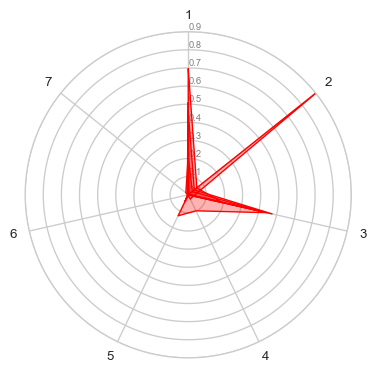

ESTATUS


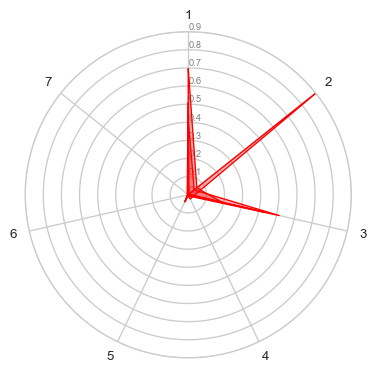

BSTELL


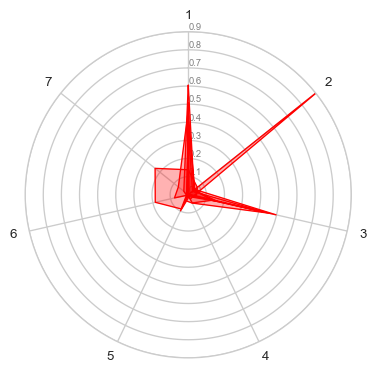

wiabt_08


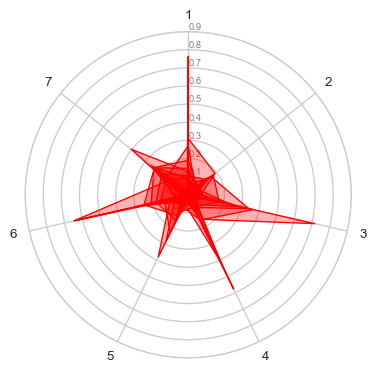

SBN2000_1


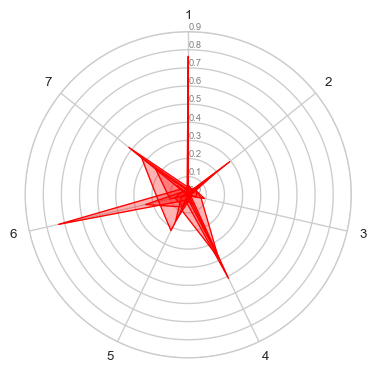

ISCO_08


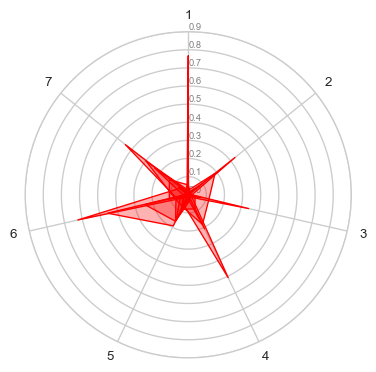

In [341]:
for feature in table4.columns.get_level_values('feature').unique():
    print(feature)
    plot_spider(table4[feature].loc[cos].T)

f40800_01


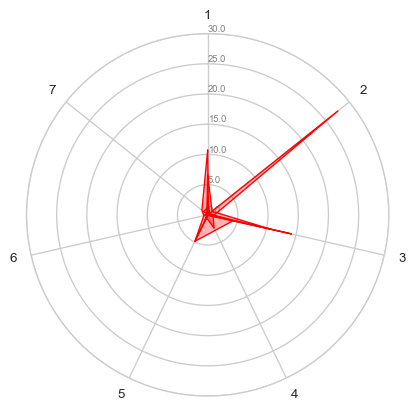

ESTATUS


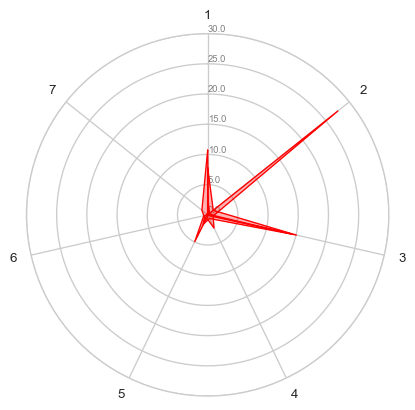

BSTELL


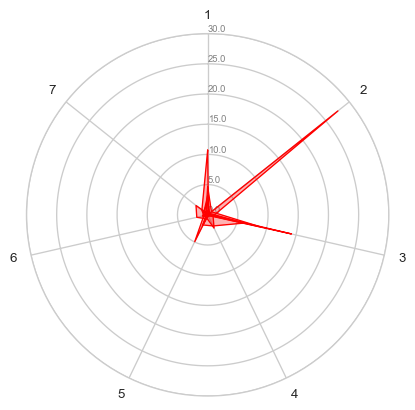

wiabt_08


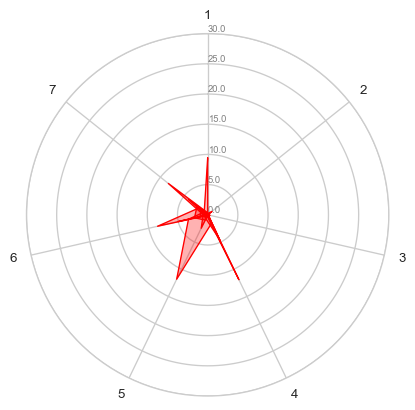

SBN2000_1


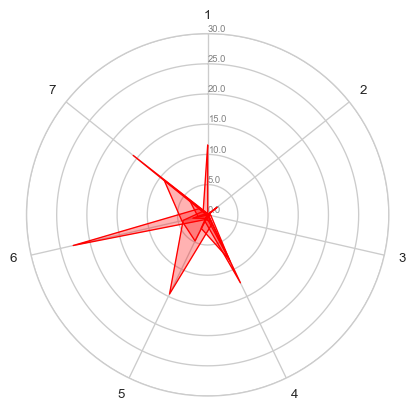

ISCO_08


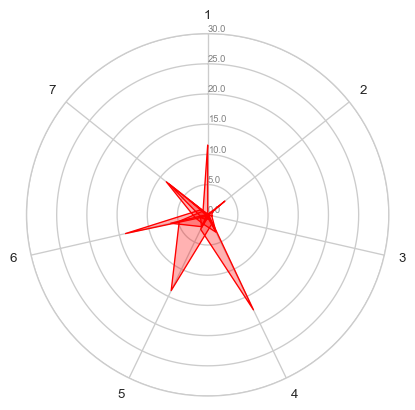

In [272]:
for feature in table4.columns.get_level_values('feature').unique():
    print(feature)
    plot_spider(table4[feature].loc[cont].T)

By using above plots and the ranking of the features we can say:
- ESTATUS and f40800_01 have similar map. Keep f40800_01 because it's espression of more components
- BSTELL and wiabt_08 are different from anything else and should be kept
- SBN2000_1 and ISCO_08 are similar. Keep ISCO_08 because it seems slightly more representative

# Classification

Simple, treating number as numerical values

In [344]:
df = df.drop(['ESTATUS','SBN2000_1'], axis=1)

In [345]:
y_col = 'target'
ratio = 0.8   # train on tot
X_train, Y_train, X_test, Y_test = get_train_test(df, y_col, ratio)

df_results = batch_classify(X_train, Y_train, X_test, Y_test)
display(df_results.sort_values(by='test_score', ascending=False))

trained Neural Net in 0.34 s
trained Linear SVM in 1.78 s
trained Logistic Regression in 0.12 s
trained Nearest Neighbors in 0.01 s
trained Gradient Boosting Classifier in 0.85 s
trained Decision Tree in 0.00 s
trained Naive Bayes in 0.00 s
trained Random Forest in 0.06 s


,classifier,train_score,test_score,training_time
1,Linear SVM,0.582888,0.551450,1.778500
4,Gradient Boosting Classifier,0.584717,0.549744,0.846411
0,Neural Net,0.560231,0.537806,0.341980
2,Logistic Regression,0.549676,0.532121,0.117484
5,Decision Tree,0.618210,0.528709,0.004557
7,Random Forest,0.617788,0.525867,0.058642
3,Nearest Neighbors,0.572615,0.521887,0.010296
6,Naive Bayes,0.535322,0.518476,0.001850


In [346]:
y_col = 'target'
ratio = 0.8   # train on tot
X_train, Y_train, X_test, Y_test = get_train_test(df, y_col, ratio)

df_results = batch_classify(X_train, Y_train, X_test, Y_test)
display(df_results.sort_values(by='test_score', ascending=False))

C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


trained Neural Net in 1.07 s


C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


trained Linear SVM in 1.86 s
trained Logistic Regression in 0.01 s
trained Nearest Neighbors in 0.01 s


C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


trained Gradient Boosting Classifier in 0.83 s
trained Decision Tree in 0.01 s
trained Naive Bayes in 0.00 s
trained Random Forest in 0.06 s


C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\giacompa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,classifier,train_score,test_score,training_time
4,Gradient Boosting Classifier,0.576424,0.570784,0.830829
5,Decision Tree,0.612944,0.560632,0.006026
0,Neural Net,0.556120,0.556120,1.071647
1,Linear SVM,0.556261,0.556120,1.857663
7,Random Forest,0.612380,0.552735,0.064647
2,Logistic Regression,0.545544,0.544839,0.013950
6,Naive Bayes,0.531867,0.540891,0.002568
3,Nearest Neighbors,0.566977,0.528483,0.014157


Moving to nominal categorical fetures

In [348]:
df = df.apply(pd.Categorical)
for col in df:
    print(col, list(df[col].cat.categories))

target [1, 2, 3]
f40800_01 [1, 2, 3, 4, 5]
BSTELL [11, 12, 20, 31, 32, 33, 40]
wiabt_08 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 88]
ISCO_08 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


With OneHotEncoder & PolynomialFeatures:

In [351]:
y_col = 'target'
ratio = 0.8   # train on tot
X_train, Y_train, X_test, Y_test = get_train_test(df, y_col, ratio)

df_results = batch_classify(X_train, Y_train, X_test, Y_test)
display(df_results.sort_values(by='test_score', ascending=False))

trained Neural Net in 3.29 s
trained Linear SVM in 64.20 s
trained Logistic Regression in 0.25 s
trained Nearest Neighbors in 0.57 s
trained Gradient Boosting Classifier in 56.36 s
trained Decision Tree in 0.55 s
trained Naive Bayes in 0.30 s
trained Random Forest in 0.87 s


,classifier,train_score,test_score,training_time
0,Neural Net,0.581608,0.566327,3.294604
4,Gradient Boosting Classifier,0.587523,0.566327,56.358493
2,Logistic Regression,0.593438,0.564626,0.245919
5,Decision Tree,0.612026,0.555556,0.552304
1,Linear SVM,0.556401,0.554989,64.201208
7,Random Forest,0.610477,0.548186,0.873181
3,Nearest Neighbors,0.569216,0.537982,0.570100
6,Naive Bayes,0.271370,0.252268,0.295793


With OneHotEncoder only:

In [358]:
y_col = 'target'
ratio = 0.8   # train on tot
X_train, Y_train, X_test, Y_test = get_train_test(df, y_col, ratio)

df_results = batch_classify(X_train, Y_train, X_test, Y_test)
display(df_results.sort_values(by='test_score', ascending=False))

pipelining...
training Neural Net
scoring Neural Net
trained Neural Net in 1.06 s
pipelining...
training Linear SVM
scoring Linear SVM
trained Linear SVM in 3.71 s
pipelining...
training Logistic Regression
scoring Logistic Regression
trained Logistic Regression in 0.04 s
pipelining...
training Nearest Neighbors
scoring Nearest Neighbors
trained Nearest Neighbors in 0.08 s
pipelining...
training Gradient Boosting Classifier
scoring Gradient Boosting Classifier
trained Gradient Boosting Classifier in 2.18 s
pipelining...
training Decision Tree
scoring Decision Tree
trained Decision Tree in 0.03 s
pipelining...
training Naive Bayes
scoring Naive Bayes
trained Naive Bayes in 0.01 s
pipelining...
training Random Forest
scoring Random Forest
trained Random Forest in 0.10 s


,classifier,train_score,test_score,training_time
1,Linear SVM,0.565342,0.571887,3.707603
0,Neural Net,0.576065,0.569749,1.063483
4,Gradient Boosting Classifier,0.581498,0.561732,2.182597
2,Logistic Regression,0.573063,0.558525,0.036162
5,Decision Tree,0.613097,0.554784,0.030084
3,Nearest Neighbors,0.589505,0.553715,0.079411
7,Random Forest,0.612096,0.545163,0.102681
6,Naive Bayes,0.359022,0.357563,0.014406


With OneHotEncoder only:

In [365]:
y_col = 'target'
ratio = 0.8   # train on tot
X_train, Y_train, X_test, Y_test = get_train_test(df, y_col, ratio)

df_results = batch_classify(X_train, Y_train, X_test, Y_test)
display(df_results.sort_values(by='test_score', ascending=False))

pipelining...
training Neural Net ...
trained Neural Net in 2.10 s
scoring Neural Net ...
pipelining...
training Linear SVM ...
trained Linear SVM in 3.74 s
scoring Linear SVM ...
pipelining...
training Logistic Regression ...
trained Logistic Regression in 0.14 s
scoring Logistic Regression ...
pipelining...
training Nearest Neighbors ...
trained Nearest Neighbors in 0.10 s
scoring Nearest Neighbors ...
pipelining...
training Gradient Boosting Classifier ...
trained Gradient Boosting Classifier in 2.19 s
scoring Gradient Boosting Classifier ...
pipelining...
training Decision Tree ...
trained Decision Tree in 0.05 s
scoring Decision Tree ...
pipelining...
training Naive Bayes ...
trained Naive Bayes in 0.02 s
scoring Naive Bayes ...
pipelining...
training Random Forest ...
trained Random Forest in 0.11 s
scoring Random Forest ...


,classifier,train_score,test_score,training_time
2,Logistic Regression,0.571997,0.571037,0.137719
0,Neural Net,0.588895,0.568294,2.095261
4,Gradient Boosting Classifier,0.582363,0.566648,2.185126
1,Linear SVM,0.589889,0.565551,3.740789
5,Decision Tree,0.614740,0.546901,0.046454
3,Nearest Neighbors,0.576257,0.543061,0.101291
7,Random Forest,0.613888,0.543061,0.113046
6,Naive Bayes,0.345782,0.340647,0.024753


With OneHotEncoder & Scaling:

In [377]:
y_col = 'target'
ratio = 0.8   # train on tot
df_results = batch_classify( list(get_train_test(df, y_col, ratio)), verbose=False)
for j in range(9):
    print("round ",j)
    df_results[["train_score","test_score","training_time"]] += batch_classify( list(get_train_test(df, y_col, ratio)), verbose=False)[["train_score","test_score","training_time"]]
df_results[["train_score","test_score","training_time"]]

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8
round  9


,train_score,test_score,training_time
0,6.480267,6.224779,22.724104
1,6.480718,6.152518,43.434926
2,6.301540,6.185437,2.042100
3,6.340516,5.931657,1.264720
4,6.412957,6.183785,26.629308
5,6.747272,6.009045,0.456969
6,3.592566,3.576939,0.295776
7,6.733726,5.993082,1.295830


In [380]:
df_results[["train_score","test_score","training_time"]] /= 11

In [382]:
df_results.sort_values(by='test_score', ascending=False)

,classifier,train_score,test_score,training_time
0,Neural Net,0.058912,0.056589,0.206583
2,Logistic Regression,0.057287,0.056231,0.018565
4,Gradient Boosting Classifier,0.058300,0.056216,0.242085
1,Linear SVM,0.058916,0.055932,0.394863
5,Decision Tree,0.061339,0.054628,0.004154
7,Random Forest,0.061216,0.054483,0.011780
3,Nearest Neighbors,0.057641,0.053924,0.011497
6,Naive Bayes,0.032660,0.032518,0.002689


In [383]:
y_col = 'target'
ratio = 0.8   # train on tot
df_results = batch_classify( list(get_train_test(df, y_col, ratio)), verbose=False)
for j in range(9):
    print("round ",j)
    df_results[["train_score","test_score","training_time"]] += batch_classify( list(get_train_test(df, y_col, ratio)), verbose=False)[["train_score","test_score","training_time"]]
df_results[["train_score","test_score","training_time"]] /= 10
df_results.sort_values(by='test_score', ascending=False)

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8


,classifier,train_score,test_score,training_time
2,Logistic Regression,0.572091,0.567256,0.186263
4,Gradient Boosting Classifier,0.582331,0.565346,2.424638
0,Neural Net,0.589458,0.564824,2.192736
1,Linear SVM,0.589540,0.562363,3.980781
5,Decision Tree,0.613251,0.552642,0.041827
3,Nearest Neighbors,0.578854,0.544586,0.113922
7,Random Forest,0.612177,0.543762,0.122934
6,Naive Bayes,0.336507,0.325759,0.027755


With all the hot encoding and plynomial features, it's worse...

**DO NOT TOUCH**, because it's also slow.

In [75]:
y_col = 'target'
ratio = 0.8   # train on tot
X_train, Y_train, X_test, Y_test = get_train_test(df, y_col, ratio)

df_results = batch_classify(X_train, Y_train, X_test, Y_test)
display(df_results.sort_values(by='test_score', ascending=False))

trained Decision Tree in 1.21 s
trained Nearest Neighbors in 0.86 s
trained Linear SVM in 108.17 s
trained Naive Bayes in 0.49 s
trained Logistic Regression in 0.43 s
trained Neural Net in 11.43 s
trained Gradient Boosting Classifier in 106.76 s
trained Random Forest in 1.49 s


,classifier,train_score,test_score,training_time
5,Neural Net,0.597514,0.567825,11.433087
1,Nearest Neighbors,0.599068,0.561099,0.862766
6,Gradient Boosting Classifier,0.599350,0.560538,106.757502
4,Logistic Regression,0.609236,0.558296,0.434189
2,Linear SVM,0.556983,0.552691,108.166522
0,Decision Tree,0.651179,0.546525,1.207856
7,Random Forest,0.649485,0.542601,1.490799
3,Naive Bayes,0.287954,0.269058,0.486775


In [130]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators = 18),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB()
}

In [133]:
{dict_classifiers['Neural Net']}.items()

AttributeError: 'set' object has no attribute 'items'